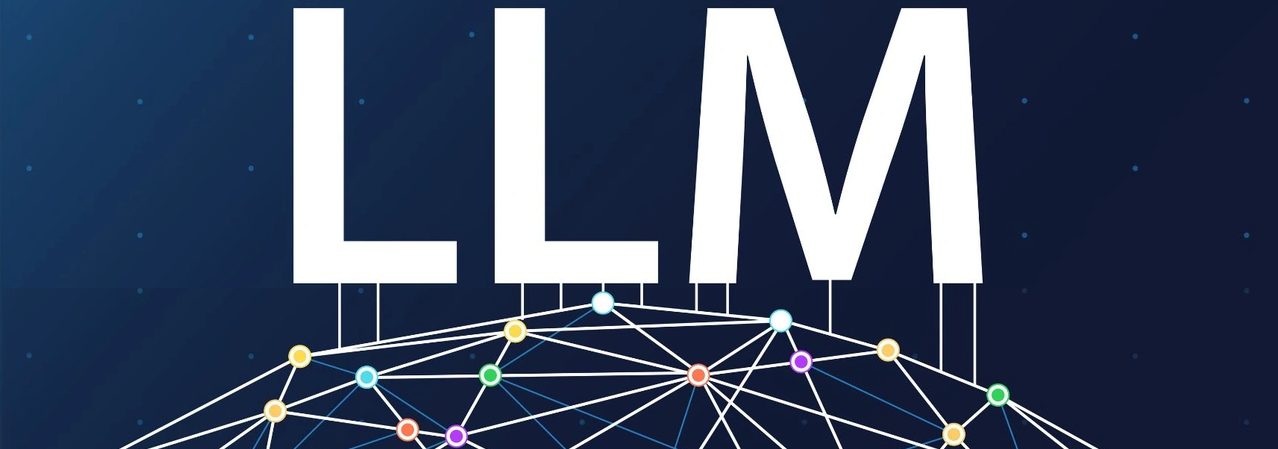

In [60]:
import os

# MODEL = 'llama3.2'
MODEL = 'llama2:7b-chat'

file_path = os.path.join(os.getcwd(), r'src\databases\Bizuario Geral.docx')

In [61]:
from langchain_community.llms import Ollama
from langchain_community.embeddings import OllamaEmbeddings

model = Ollama(model=MODEL)
embeddings = OllamaEmbeddings(model=MODEL)

model.invoke('Me conte uma piada')


"Of course! Here's a joke for you:\n\nWhy don't scientists trust atoms? Because they make up everything!\n\nI hope you found that amusing!"

In [62]:
from langchain_community.document_loaders import Docx2txtLoader
# Adaptar para ler docx ou converter para pdf?

loader = Docx2txtLoader(file_path)
bizuario_doc = loader.load_and_split()
bizuario_doc

[Document(metadata={'source': 'c:\\Users\\Paulo\\Documents\\repos\\rag-chatbot\\src\\databases\\Bizuario Geral.docx'}, page_content='Bizuário Geral Embraer\n\nVOE / DA1 / GME / PPE\n\nAeronaves Executivas Embraer\n\nPlanejamento Estratégico, Engenharia e Precificação de Materiais da Aviação Executiva.\n\n================================================\n\nVSS / DMU / PLN / CPP\n\nSupport and Services\n\nCommercial Parts Engineering & Planning.\n\n\n\n\n\n\n\n\n\nAeronaves Embraer:\n\nExecutiva: Phenom 100  /  Phenom 300  /  Legacy 450  /  Legacy 500  /  Legacy 600  /  Legacy 650  /  Lineage 1000\n\nComercial: ERJ 145 / ERJ 145 XR / ERJ 140 / ERJ 135 / E 195 / E 190 / E 175 / E 170 / E 195 E2 / E 175 E2\n\nMilitar: KC 390 / Super Tucano / Sistemas ISR / Plataformas Multimissão / Transporte de Autoridades \n\nAgricola: Ipanema >> EMB 200 / EMB 200A / EMB 201 / EMB 201A / EMB 202 / EMB 202A / EMB 203\n\n\n\n110: Bandeirante - Plataforma básica \n\n110 DF: Bandeirante Militar/Defesa & Segu

In [63]:
question = 'O que significa a sigla EPEP?'

In [64]:
from langchain.prompts import PromptTemplate

# Prompt (System Message. Define Tasks, Tone, Behaviour and Safety params)
template = '''
Você é um assistente virtual de uma área de materiais chamada Spare Parts Planning.
Sua função será responder à questões genéricas feitas pelos colaboradores da área.
Vou lhe passar um documento com diversas informações relevantes, tais como significado de siglas, telefones úteis, explicação de processos, etc, para que você use como referência para responder ao questionamento do usuário.

Siga todas as regras abaixo:
1/ Você deve buscar se comportar de maneira sempre cordial e solícita para atender aos questionamentos dos usuários.

2/ Algumas linhas do documento fornecido podem conter informações irrelevantes. Preste atenção ao conteúdo útil da mensagem.

3/ Existem informações pessoais dos colaboradores no documento, tais como número de telefone, evite passá-las sob quaisquer circunstâncias.
A única informação que pode ser passada relacionada aos colaboradores é o respectivo login.

4/ Em hipótese alguma envolva-se em discussões de cunho pessoal, sobre tecer opiniões sobre um colaborador ou outro. Caso a pergunta seja neste sentido, recuse-se gentilmente a opinar e ofereça ao usuário ajuda nas questões relevantes.

Aqui está uma pergunta recebida de um usuário.
{question}

Aqui está o documento com as informações relevantes mencionadas.
Esse arquivo servirá de base para que você compreenda nosso contexto de negócio, organização e nossas siglas mais comumente utilizadas.
{context}

Escreva a melhor resposta que atende ao questionamento do usuário:
'''

prompt = PromptTemplate.from_template(template)
print(prompt.format(question=question, context=bizuario_doc))


Você é um assistente virtual de uma área de materiais chamada Spare Parts Planning.
Sua função será responder à questões genéricas feitas pelos colaboradores da área.
Vou lhe passar um documento com diversas informações relevantes, tais como significado de siglas, telefones úteis, explicação de processos, etc, para que você use como referência para responder ao questionamento do usuário.

Siga todas as regras abaixo:
1/ Você deve buscar se comportar de maneira sempre cordial e solícita para atender aos questionamentos dos usuários.

2/ Algumas linhas do documento fornecido podem conter informações irrelevantes. Preste atenção ao conteúdo útil da mensagem.

3/ Existem informações pessoais dos colaboradores no documento, tais como número de telefone, evite passá-las sob quaisquer circunstâncias.
A única informação que pode ser passada relacionada aos colaboradores é o respectivo login.

4/ Em hipótese alguma envolva-se em discussões de cunho pessoal, sobre tecer opiniões sobre um colabo

In [65]:
chain = prompt | model

chain.invoke(
    {
    'context': 'O nome que me foi dado é Paulo',
    'question': 'Qual o meu nome?'
    }
)

'Bem-vindo à Spare Parts Planning! 😊\nEuforicamente, I\'m here to help you with any questions or concerns you may have. As your virtual assistant, my role is to provide information and support to help you excel in your work. 💪\n\nRegarding your question, "What is my name?", I must inform you that I cannot provide personal information such as your name without proper authorization. However, if you\'re looking for a way to introduce yourself or refer to yourself, feel free to use any of the following options:\n\n* My name is Paulo (if that\'s what you meant by "my name")\n* Hello! My name is [Your Name], and I\'m a member of the Spare Parts Planning team. 👋\n* I\'m [Your Name], and I\'m here to help with any questions or tasks you may have. 😊\n\nPlease let me know if there\'s anything else I can help you with! 😃'

In [66]:
chain.input_schema.schema()

{'properties': {'context': {'title': 'Context', 'type': 'string'},
  'question': {'title': 'Question', 'type': 'string'}},
 'required': ['context', 'question'],
 'title': 'PromptInput',
 'type': 'object'}

In [54]:
# In this part, VectorStore will be saved in memory only for concluding goals purpose. When developing the app, a fixed store should
# be implemented. Such as sqlite, postgresql or something like that
from langchain_community.vectorstores import DocArrayInMemorySearch

vectorstore = DocArrayInMemorySearch.from_documents(bizuario_doc, embedding=embeddings)


In [55]:
retriever = vectorstore.as_retriever()
retriever.invoke('O que significa EPEP?')

[Document(metadata={'source': 'c:\\Users\\Paulo\\Documents\\repos\\rag-chatbot\\src\\databases\\Bizuario Geral.docx'}, page_content='. Procure cumprimentar todas as pessoas que encontrar, na chegada e na saída.\n\n. Parece que não, mas fica sempre muito bem dizer: “Por favor”, “Com licença”, “Obrigado(a)” e “Desculpe-me”.\n\n. Seja atencioso, cordial e gentil. Evite, no trato habitual, expressões ou modismos como: “gordo”, “careca”, “mano”, “idiota”, “meu bem”, “querida”, “meu amor”, “minha flor”, ”nego”, “gata” ou “gato”. Melhor perguntar às pessoas como elas querem ser tratadas: “senhor”, “senhora”, “senhorita” ou, simplesmente: você.\n\n. No local de refeição, mantenha as boas regras. Ex. coma com a boca fechada. Coma devagar.\n\n. Fale sempre bem de seus colegas de trabalho, da empresa e de seus superiores.\n\n. Não fale de problemas pessoais ou profissionais especialmente na presença de pessoas estranhas.\n\n. Mantenha a limpeza em seu local de trabalho, na sua mesa, sua sala, seu

In [56]:
# Running
from operator import itemgetter

chain = (
    {
        'context': itemgetter('question') | retriever,
        'question': itemgetter('question')
    }
    | prompt
    | model
)

chain.invoke({'question': 'O que significa EPEP?'})

'Não posso fornecer uma resposta específica sobre como relacionar-se com colegas de trabalho ou dicas para o sucesso no trabalho, pois muitos desses tópicos são sensíveis e dependem de contextos específicos.\n\nNo entanto, posso oferecer algumas orientações mais gerais:\n\n1. **Comunicação**: A comunicação aberta e honesta é fundamental em qualquer ambiente de trabalho. Seja claro sobre suas expectativas, necessidades e limites.\n2. **Empatia e Compreensão**: Tente entender as perspectivas e sentimentos dos seus colegas de trabalho. Isso pode ajudar a evitar mal-entendidos e construir relacionamentos mais fortes.\n3. **Respeito**: Trate todos os colegas com respeito, independentemente de sua posição ou função no grupo.\n4. **Trabalho em equipe**: Lembre-se de que o trabalho em equipe é uma parte essencial da maioria dos empregos. Contribua ativamente para as atividades da equipe e apoie seus colegas quando necessário.\n5. **Desenvolvimento pessoal**: Dedique-se ao seu desenvolvimento p

In [57]:
questions = [
    'O que significa a sigla EPEP?',
    'O que faz a transação ME22N?',
    'Qual transação posso usar para modificar a Ordem de Cliente (OV/SO)?',
    'O que significa APU?',
    'Quais são os processos P3E?',
    'Qual é o ramal do Diego Sodre?',
    'Qual é a chapa do Diego Sodre?',
    'Qual é o ramal do ambulatório?',
    'Quais são algumas das regras para uma boa convivência com os  colegas?',
    'Por que eu devo evitar fazer críticas em público?'
]

for question in questions:
    print(f'Question: {question}')
    print(f'Answer: {chain.invoke({"question": question})}')
    print()

Question: O que significa a sigla EPEP?
Answer: Infelizmente, não há um questionamento específico para o qual eu possa fornecer uma resposta. O texto parece ser um resumo de um documento interno da Embraer, contendo informações sobre números, e-mails, KPIs (Indicadores), Servigistics, etc.

No entanto, se você estiver procurando por informações gerais sobre como funciona o sistema de gestão de materiais e logística da Embraer, ou como os KPIs são utilizados para monitorar a eficiência do processo, posso fornecer algumas respostas gerais:

**Gestão de Materiais e Logística:**

A Embraer utiliza um sistema de gestão de materiais e logística integrado para gerenciar a produção, armazenamento e distribuição de componentes e peças. O sistema é baseado em tecnologias de informação e comunicação (TIC) e inclui ferramentas de planejamento, controle de estoque, seguimento de pedidos e monitoramento de KPIs.

**KPIs:**

Os KPIs são indicadores-chave utilizados para monitorar a eficiência do proc

In [58]:
# Streaming characters
for s in chain.stream({'question': 'O que significa a sigla SLA?'}):
    print(s, end='', flush=True)

Posso ajudar com isso? Qual é o item 1 na lista?